/var/folders/_y/lv1c_67123130wz2m520mbc40000gn/T/ipykernel_42431/2775680639.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat(full_df)


Loaded rows: 128453
Selected athlete: PLAYER_541


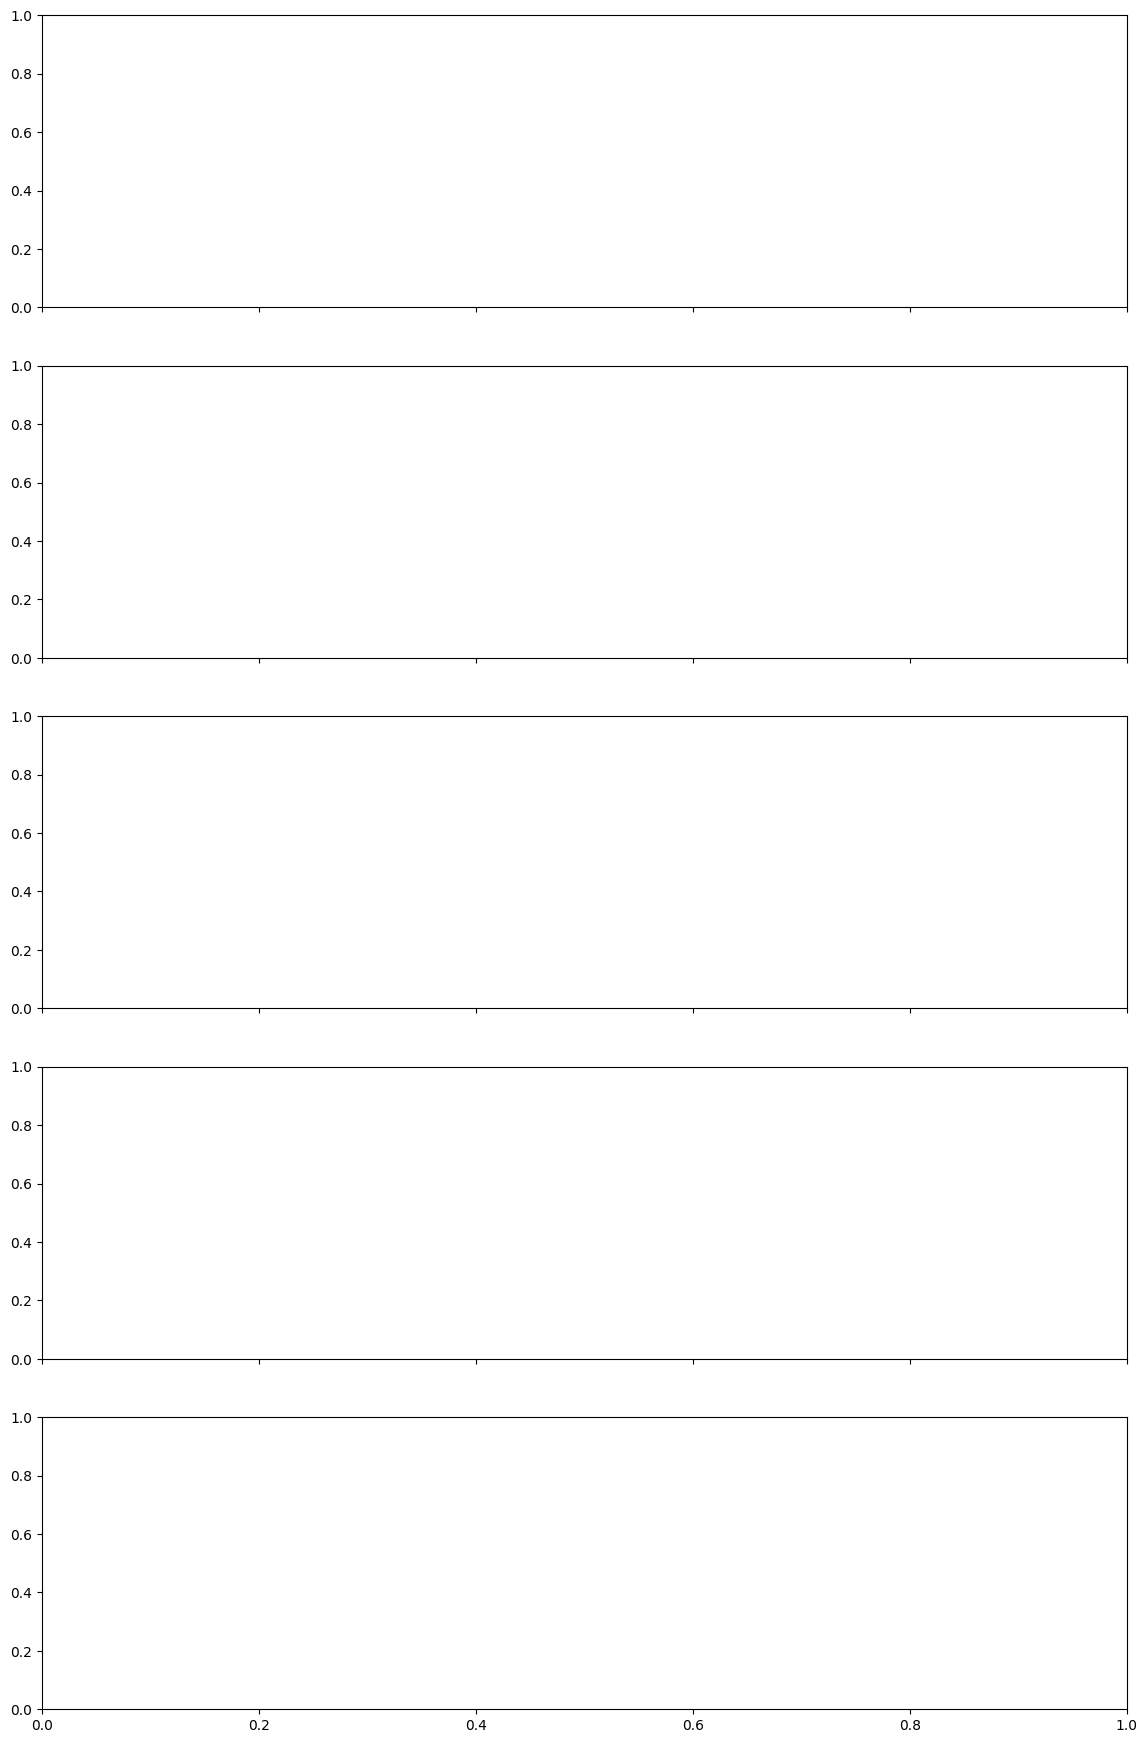

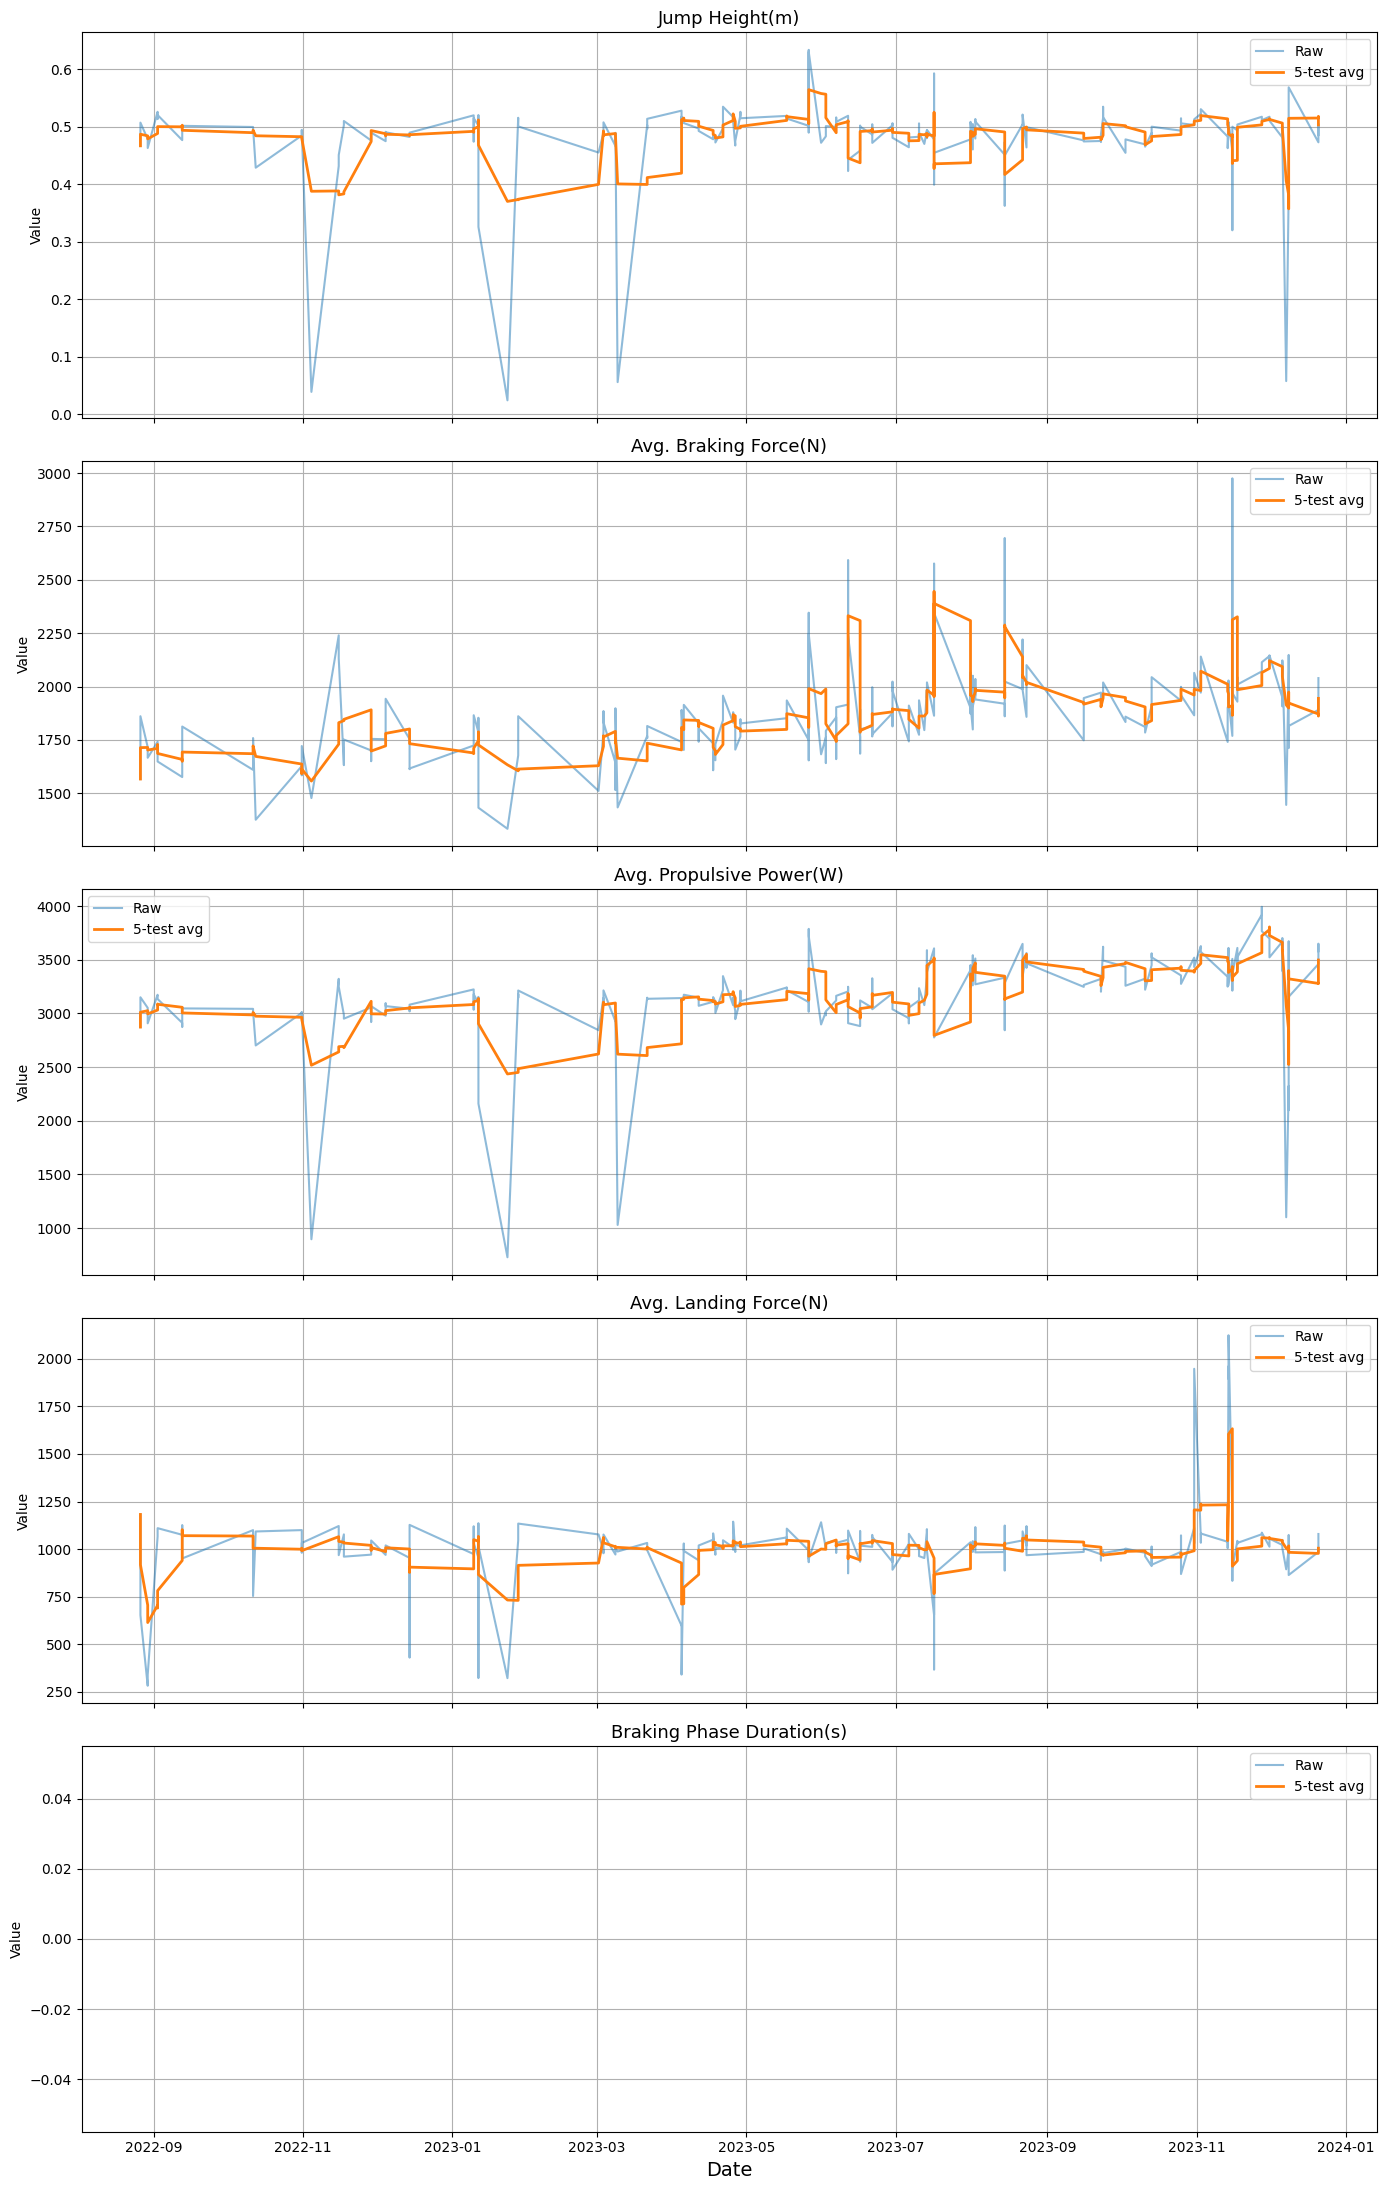

In [ ]:
from sqlalchemy import create_engine
import pandas as pd
import os
from dotenv import load_dotenv
import sqlalchemy
from sqlalchemy import create_engine, text
import pymysql
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats 
from sqlalchemy.exc import OperationalError, ProgrammingError 
from datetime import datetime, timedelta


load_dotenv('test.env')
load_dotenv('test.env', override=True)

sql_username = os.getenv('DB_USER')
sql_password = os.getenv('DB_PASSWORD')
sql_host = os.getenv('DB_HOST')
sql_database = os.getenv('DB_NAME')

sql_username

# with SSL off

url_string = f"mysql+pymysql://{sql_username}:{sql_password}@{sql_host}:3306/{sql_database}"

conn = create_engine(url_string)

metrics_list = [
    "Jump Height(m)",
    "Avg. Braking Force(N)",
    "Avg. Propulsive Power(W)",
    "Avg. Braking Power(W)",
    "Braking Phase Duration(s)"
]

# -------- Load df for all metrics --------
full_df = []

for m in metrics_list:
    query = text(f"""
        SELECT timestamp, playername, metric, value
        FROM {os.getenv('DB_TABLE')}
        WHERE metric = '{m}'
    """)
    df = pd.read_sql(query, conn)
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["metric_name"] = m
    full_df.append(df)

full_df = pd.concat(full_df)
print("Loaded rows:", len(full_df))

# -------- Pick athlete with highest number of total tests --------
athlete = full_df["playername"].value_counts().index[0]
print("Selected athlete:", athlete)

athlete_df = full_df[full_df["playername"] == athlete]

# -------- Create figure with 5 subplots --------
fig, axes = plt.subplots(len(metrics_list), 1, figsize=(14, 22), sharex=True)

# -------- Create figure with 5 subplots --------
fig, axes = plt.subplots(len(metrics_list), 1, figsize=(14, 22), sharex=True)

for i, metric in enumerate(metrics_list):
    df_m = athlete_df[athlete_df["metric_name"] == metric].sort_values("timestamp")

    # Rolling smoothing
    df_m["rolling"] = df_m["value"].rolling(5, min_periods=1).mean()

    axes[i].plot(df_m["timestamp"], df_m["value"], label="Raw", alpha=0.5)
    axes[i].plot(df_m["timestamp"], df_m["rolling"], label="5-test avg", linewidth=2)

    axes[i].set_title(metric, fontsize=13)
    axes[i].set_ylabel("Value")
    axes[i].grid(True)
    axes[i].legend()

plt.xlabel("Date", fontsize=14)
plt.tight_layout()
plt.show()
